## Handwritten Digit Recogonition (MNSIT Dataset)

 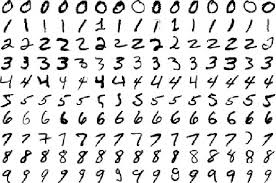
    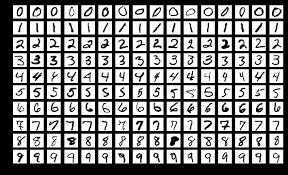







**History of Handwritten Digit dataset**

Modified National Institute of Standards and Technology database (MNIST dataset) is a large dataset of handwritten digits which is widely used in image processing and machine learning. The set of images in the MNIST database is a combination of two of NIST's databases: Special Database 1 and Special Database 3. Special Database 1 and Special Database 3 consist of digits written by high school students and employees of the United States Census Bureau, respectively.



**Why to start with MNIST dataset?**

The MNIST dataset is a well-known dataset for image classification. Tensorflow and Keras also provide MNIST dataset directly through their APIs. For the learning purpose, the MNIST dataset is easy to use and experiment with different machine learning techniques.

**About the Notebook**


*   In this notebook, I have covered the necessary steps to approach any Machine Learning Classification Problem.
*   Included Image Visualization for better understanding.
*   Quick Links to the functions I have used to explore it in depth.
*   Basic techniques such as k-folds, using Callbacks, etc.

I have tried to make this notebook as simple as possible, along with covering the basic approach to tackle any classification task.



**Task**

The task is to classify the images in 10 class, i.e., [0-9], inclusively.

## Required Imports

**Imports:**


1.   pandas : For handeling csv dataset
2.   numpy : Support for Pandas and calculations
3.   Matplotlib - For visualization (Plotting graphs)
4.   keras - Prediction Models
5.   tensorflow - Prediction Models



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import os


import matplotlib.pyplot as plt
import pickle

%matplotlib inline

## Loading and Visualizing Dataset


---


**About Dataset**

MNIST dataset has the following features:


*   Dataset size 60,000 samples of handwritten images.
*   The size of each image is 28x28 pixels.
*   Each image has only 1 color channel, i.e., grayscale image.
*   Each pixel has value in the range of [0,255] where 0 represents black, and 255 represents white.
*   Each image has labeled from 0-9.

**Loading Training and testing Data**




In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print("The shape of training dataset -", X_train_full.shape)
print("Each pixel intensity is also represented as a byte(0-255) -", X_train_full.dtype)

The shape of training dataset - (60000, 28, 28)
Each pixel intensity is also represented as a byte(0-255) - uint8


Prepairing **Validation data** and **Normalizing the data**

**It requires a few steps:**


*   Assuming the validation set size. I am taking it 10% of the training set. 
*   Splitting training set into a training set (90% original training set) and validation set (10% original training set) from the training dataset.
*   scaling down the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255
*   Splitting the labels for both training set and validation set.



In [4]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Shape of training set

In [5]:
X_train.shape, y_train.shape

((55000, 28, 28), (55000,))

## Visualize Digits dataset


---

**Visualizing the digits by plotting Images**

This will plot the first 40 images of diits with the label.

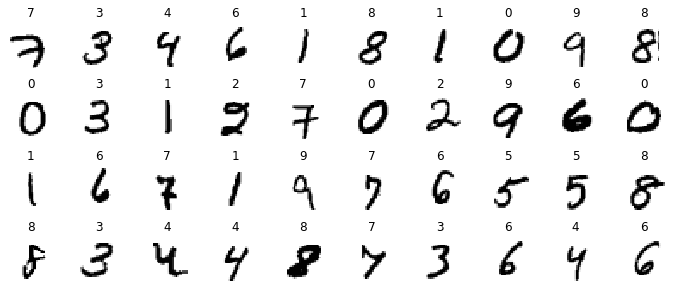

In [6]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)    
plt.show()

**Visualising one digit**


---

This will plot an image of the first digit in the dataset.

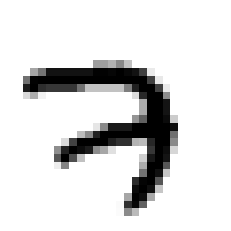

7


In [7]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()
print(y_train[0])

## **Building Model**


---







**Model Using Keras**

There are two different ways of defining the Model in Keras:


*   Sequential Model
*   Function API

Functional API is used to build a more complicated Model such as for multi-output Models, directed acyclic graphs, or models with shared layers. I am using the Sequential Model in this notebook to keep things simple.
In Sequential Model, you can add each layer sequentially.



Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [8]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
  def __init__(self, factor):
    self.factor = factor
    self.rates = []
    self.losses = []
  def on_batch_end(self, batch, logs):
    self.rates.append(K.get_value(self.model.optimizer.lr))
    self.losses.append(logs["loss"])
    K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [9]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005) # increasing by 0.5% factor at each iterton


Now let's train the model for just 1 epoch:

In [12]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 6s 3ms/step - loss: 38081929542287021309952.0000 - accuracy: 0.5762 - val_loss: 2.3911 - val_accuracy: 0.1126


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

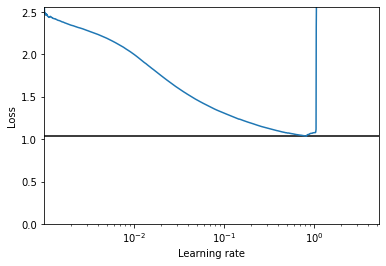

In [13]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently around 3e-1, so let's try using 2e-1 as our learning rate:

In [14]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [17]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnsit_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnsit_logs/run_001'

In [18]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnsit_model.h5", save_best_only=True)
tenorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb, tenorboard_cb])


Epoch 1/100
   1/1719 [..............................] - ETA: 0s - loss: 2.5649 - accuracy: 0.0625WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2375 - accuracy: 0.9271 - val_loss: 0.1052 - val_accuracy: 0.9674
Epoch 2/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0935 - accuracy: 0.9713 - val_loss: 0.0917 - val_accuracy: 0.9752
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0647 - accuracy: 0.9791 - val_loss: 0.0735 - val_accuracy: 0.9784
Epoch 4/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0463 - accuracy: 0.9846 - val_loss: 0.0791 - val_accuracy: 0.9780
Epoch 5/100
1719/1719 [==============================] -

See, our model compilation stopped at around 23-29 epochs that means our best model is somewhere here and there

In [21]:
model = keras.models.load_model("my_mnsit_model.h5") # rolling back to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.0977


[0.061620958149433136, 0.09769999980926514]

We got over 97% accuracy. Finally 😃

In [22]:
valid_p = np.argmax(model.predict(X_valid), axis=1)

## Visualizing Result


---

#### All Errors in the Validation set

Let's see all the errors in the validation set. It seems that in most of the cases, the recognition of digits is difficult for even humans. So we can say that our model is performing well.

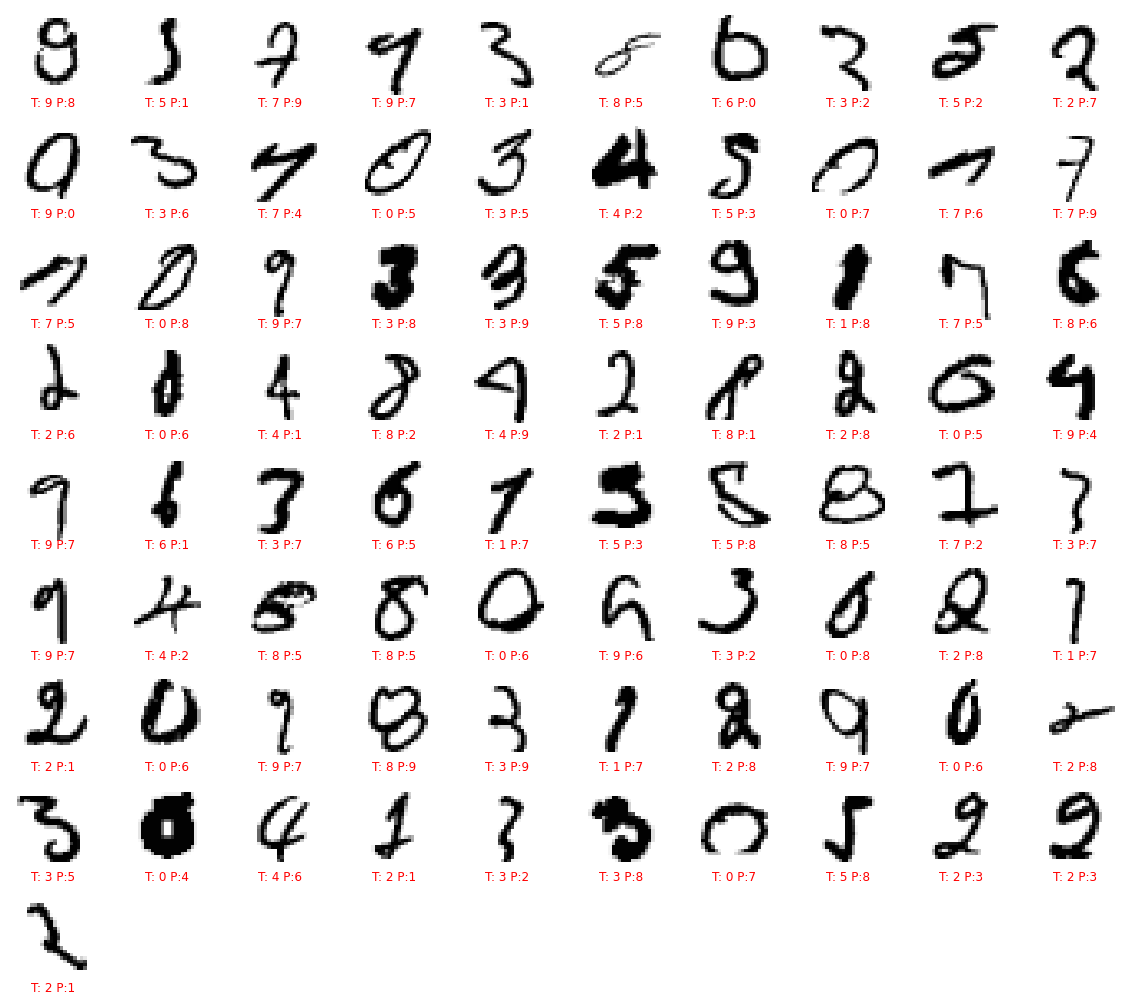

In [25]:
rows = 10
cols = 10

f = plt.figure(figsize=(2*cols,2*rows))
sub_plot = 1
for i in range(X_valid.shape[0]):
    if y_valid[i]!=valid_p[i]:
        f.add_subplot(rows,cols,sub_plot) 
        sub_plot+=1
        plt.imshow(X_valid[i].reshape([28,28]),cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title("T: "+str(y_valid[i])+" P:"+str(valid_p[i]), y=-0.15,color="Red")
plt.show()

## Predict on Testset

In [26]:
y_test = np.argmax(model.predict(X_test), axis=1)

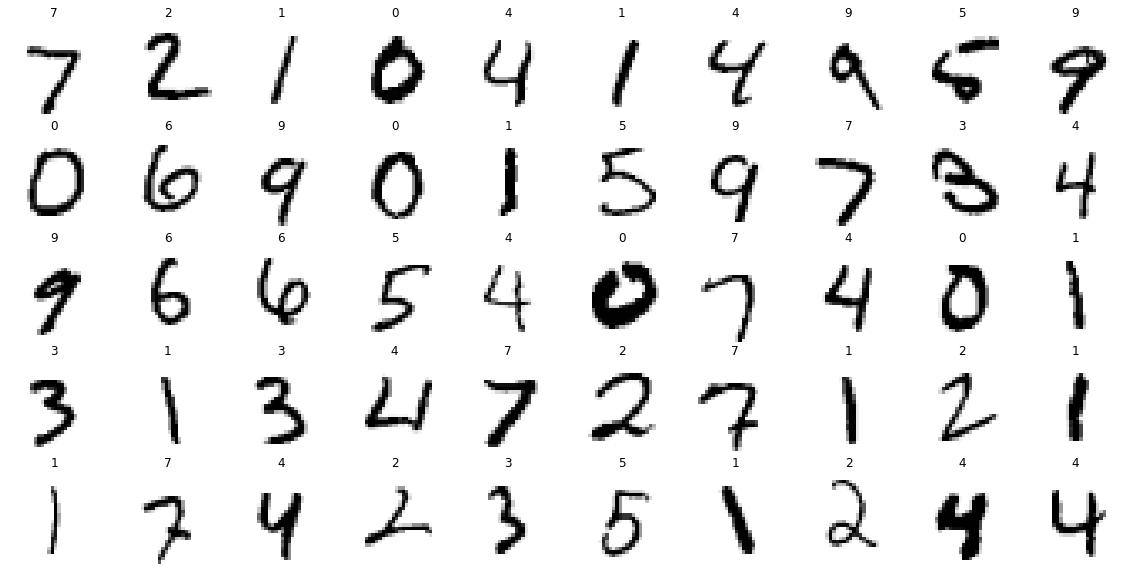

In [27]:
rows = 5
cols = 10

f = plt.figure(figsize=(2*cols,2*rows))

for i in range(rows*cols):
    f.add_subplot(rows,cols,i+1)
    plt.imshow(X_test[i].reshape([28,28]),cmap="binary")
    plt.axis("off")
    plt.title(str(y_test[i]))